In [1]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim import AdamW
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.metrics import classification_report, f1_score
import torch.nn.functional as F
import matplotlib.pyplot as plt
from transformers import  get_linear_schedule_with_warmup, AutoModel, AutoTokenizer
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

/Users/ritkumar17/Desktop/R&D_Project/LLM_fine/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer
import pandas as pd

def embedded_generation(model_name, texts, batch_size=8):
    # Load model and tokenizer once
    model = AutoModel.from_pretrained("/Users/ritkumar17/Desktop/R&D_Project/LLM_fine/llm_fine/LLM_fine_Tune")
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    texts = list(np.unique(texts))
    if model_name == "openai-community/gpt2":
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        model.resize_token_embeddings(len(tokenizer))  # GPT-2 needs resizing for new token
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_embeddings = []

    for i in range(0, len(texts), batch_size):
        torch.mps.empty_cache()  
        batch = texts[i:i + batch_size]
        inputs = tokenizer(batch, add_special_tokens=False, padding=True, truncation=True,
                           return_tensors="pt", return_attention_mask=True)

        inputs = {key: val.to(device) for key, val in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
            embeddings = outputs.last_hidden_state

        attention_mask = inputs["attention_mask"].unsqueeze(-1)
        filtered_embeddings = embeddings * attention_mask
        sentence_embeddings = filtered_embeddings.sum(dim=1) / attention_mask.sum(dim=1)

        batch_df = pd.DataFrame(sentence_embeddings.cpu().numpy())
        batch_df["text"] = batch
        all_embeddings.append(batch_df)

    return pd.concat(all_embeddings, ignore_index=True)


In [8]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_embedding_similarity(data_df, label_col="issue_area", emb_col="embedding"):
    class_names = data_df[label_col].unique()
    results = {"intra_class": {}, "inter_class": {}}

    # Intra-class similarity
    for cls in class_names:
        cls_embeddings = np.vstack(data_df[data_df[label_col] == cls][emb_col].values)
        if len(cls_embeddings) > 1:
            sim_matrix = cosine_similarity(cls_embeddings)
            np.fill_diagonal(sim_matrix, np.nan)
            avg_sim = np.nanmean(sim_matrix)
            results["intra_class"][cls] = round(avg_sim, 4)
        else:
            results["intra_class"][cls] = np.nan  # Will be skipped in plot

    # Inter-class similarity
    for cls1, cls2 in combinations(class_names, 2):
        emb1 = np.vstack(data_df[data_df[label_col] == cls1][emb_col].values)
        emb2 = np.vstack(data_df[data_df[label_col] == cls2][emb_col].values)
        sim_matrix = cosine_similarity(emb1, emb2)
        avg_sim = np.mean(sim_matrix)
        results["inter_class"][f"{cls1} vs {cls2}"] = round(avg_sim, 4)

    # Convert to DataFrame
    intra_df = pd.DataFrame.from_dict(results["intra_class"], orient='index', columns=["Avg Intra-Class Similarity"])
    inter_df = pd.DataFrame.from_dict(results["inter_class"], orient='index', columns=["Avg Inter-Class Similarity"])

    # 📊 Plot Intra-Class Barplot
    valid_intra = intra_df.dropna()
    plt.figure(figsize=(8, 5))
    sns.barplot(x="Avg Intra-Class Similarity", y=valid_intra.index, data=valid_intra, palette="viridis")
    plt.title("Intra-Class Cosine Similarity")
    plt.xlabel("Average Cosine Similarity")
    plt.ylabel("Class")
    plt.tight_layout()
    plt.show()

    # 🔥 Plot Inter-Class Heatmap
    pairs = [tuple(x.split(" vs ")) for x in inter_df.index]
    classes = sorted(set([c for pair in pairs for c in pair]))
    sim_matrix = pd.DataFrame(index=classes, columns=classes, data=np.nan)

    for idx, row in inter_df.iterrows():
        cls1, cls2 = idx.split(" vs ")
        sim_matrix.loc[cls1, cls2] = row["Avg Inter-Class Similarity"]
        sim_matrix.loc[cls2, cls1] = row["Avg Inter-Class Similarity"]  # symmetry

    plt.figure(figsize=(10, 8))
    sns.heatmap(sim_matrix, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
    plt.title("Inter-Class Cosine Similarity Heatmap")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return intra_df.sort_values("Avg Intra-Class Similarity", ascending=False), inter_df.sort_values("Avg Inter-Class Similarity", ascending=False)


In [9]:
df = pd.read_parquet("/Users/ritkumar17/Desktop/R&D_Project/LLM_fine/llm_fine/clean_dataset.parquet")

In [10]:
model_name = "bert-base-uncased"

In [11]:
embeddings_df = embedded_generation(model_name, df["conversation"].to_list())

In [12]:
data_df = embeddings_df.merge(df, how="inner", left_on = "text", right_on = "conversation")

In [13]:
data_df.drop(columns=["conversation", "text"], inplace=True)

/var/folders/00/rndss5vd6h9cdr24fwvnz6kw0000gp/T/ipykernel_95223/2906279304.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Avg Intra-Class Similarity", y=valid_intra.index, data=valid_intra, palette="viridis")


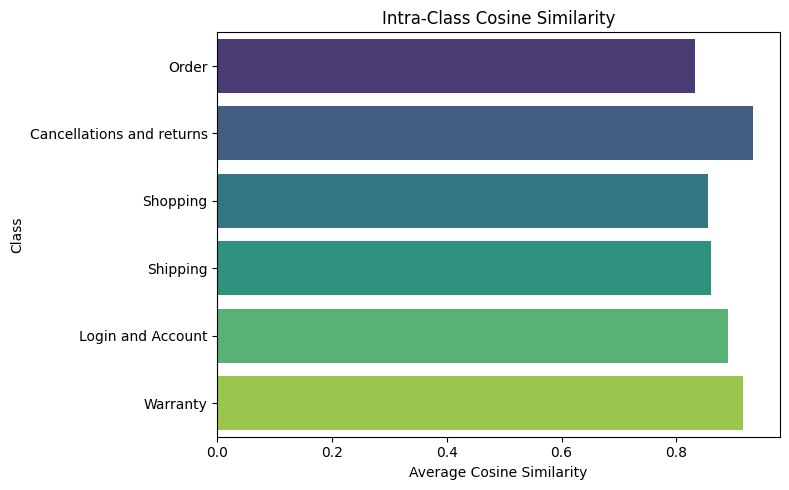

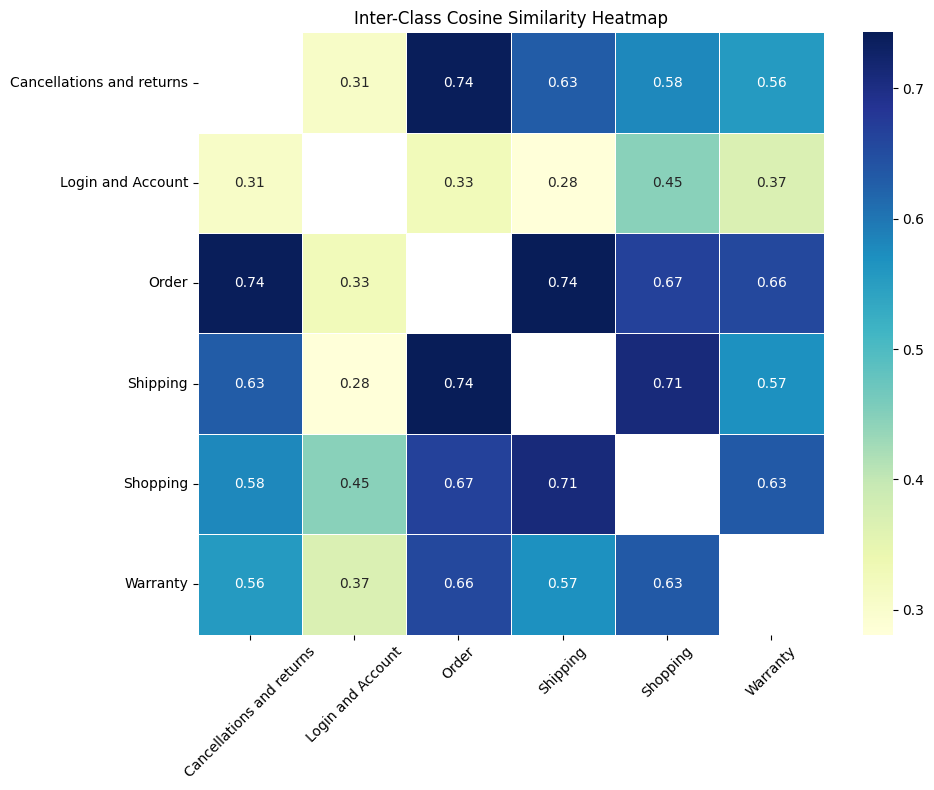

(                           Avg Intra-Class Similarity
 Cancellations and returns                      0.9340
 Warranty                                       0.9170
 Login and Account                              0.8900
 Shipping                                       0.8607
 Shopping                                       0.8559
 Order                                          0.8328,
                                                 Avg Inter-Class Similarity
 Order vs Shipping                                                   0.7430
 Order vs Cancellations and returns                                  0.7398
 Shopping vs Shipping                                                0.7092
 Order vs Shopping                                                   0.6668
 Order vs Warranty                                                   0.6570
 Shopping vs Warranty                                                0.6339
 Cancellations and returns vs Shipping                               0.6304
 Cance

In [14]:
data_df["embedding"] = data_df.iloc[:, 0:768].apply(lambda row: np.array(row), axis=1)
analyze_embedding_similarity(data_df)



/Users/ritkumar17/Desktop/R&D_Project/LLM_fine/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ritkumar17/Desktop/R&D_Project/LLM_fine/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


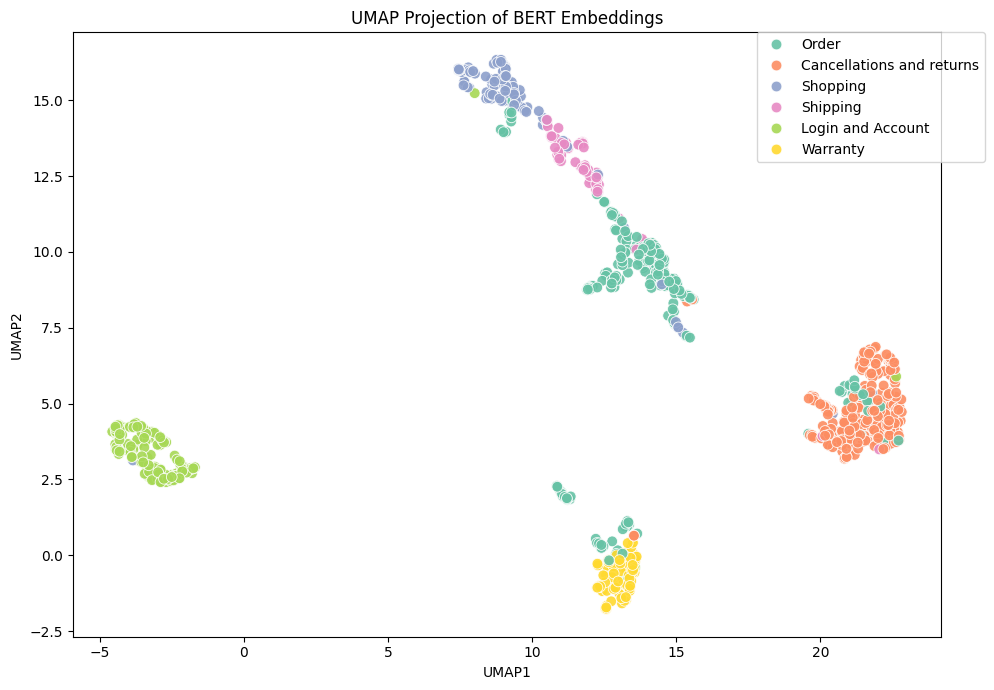

In [15]:
import pandas as pd
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
# Assuming data_df has columns: 'embedding' (list/array), and 'issue_area' (labels)

# Stack embeddings into a single numpy array
X = np.vstack(data_df['embedding'].values)
y = data_df['issue_area'].values

# Reduce to 2D using UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
X_umap = reducer.fit_transform(X)

# Create a DataFrame for plotting
plot_df = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])
plot_df['issue_area'] = y

# Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(data=plot_df, x='UMAP1', y='UMAP2', hue='issue_area', palette='Set2', s=60, alpha=0.9)
plt.title('UMAP Projection of BERT Embeddings')
plt.legend(loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()


In [ ]:
# from sklearn.decomposition import PCA
# import umap
# import matplotlib.pyplot as plt
# import seaborn as sns

# # `embeddings`: your sentence embeddings
# # `labels`: your intent labels

# reducer = umap.UMAP(n_neighbors=10, min_dist=0.3, metric='cosine')
# embedding_2d = reducer.fit_transform(data_df["embedding"])

# plt.figure(figsize=(10, 6))
# sns.scatterplot(x=embedding_2d[:, 0], y=embedding_2d[:, 1], hue=data_df["issue_area"], palette="tab10")
# plt.title("UMAP Visualization of Sentence Embeddings")
# plt.show()


In [17]:
data_df_X= data_df.drop(columns=["label", "issue_area", "embedding"])

In [18]:
data_df_Y = data_df["issue_area"]

In [19]:
train_x, test_x , train_y, test_y = train_test_split(data_df_X,data_df_Y, test_size=0.2, stratify=data_df_Y, random_state=22 )

In [20]:
train_x, val_x, train_y, val_y = train_test_split(train_x,train_y, test_size=0.125, stratify=train_y, random_state=22 )

In [21]:
train_x

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
131,-0.390342,0.069098,0.002148,-0.087253,0.058754,-0.106810,-0.153096,0.132782,-0.154621,0.020764,...,-0.101796,-0.371055,0.286423,-0.656641,-0.575614,0.363533,-0.097028,0.824308,-0.413407,-0.086275
77,-0.411435,-0.533378,0.761206,0.272214,0.044630,-0.523117,-0.339812,0.091580,0.067951,-0.253641,...,-0.585452,-0.540486,-0.362493,-0.462344,-0.686165,0.033079,0.017265,-0.143611,-0.028315,-0.646505
482,0.337411,-0.003815,0.699564,-0.556362,0.426575,-0.662509,0.804570,0.361817,-0.237761,-0.376088,...,0.393266,0.353952,-0.439121,0.415729,0.495495,0.478044,-0.093461,0.381838,-0.242797,0.499404
485,0.231225,0.341694,0.482153,0.042007,0.175216,-0.631778,-0.390891,0.269746,-0.498554,-0.024680,...,-0.004782,0.232740,0.026669,-0.103933,0.045915,-0.137544,-0.162025,0.619968,0.281648,0.091502
34,0.316806,0.033933,0.745412,-0.591435,0.547103,-0.994603,1.049093,0.412981,0.271962,-0.308530,...,0.829080,0.179617,-0.081240,0.458342,0.668802,-0.067101,-0.144354,0.011302,-0.273112,0.332433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575,-0.227047,-0.210756,0.310047,-0.159731,0.237894,0.288322,-0.440763,0.186128,-0.094400,-0.354908,...,-0.033272,-0.407747,-0.168745,-0.494104,-0.686005,0.570479,-0.332950,0.645748,-0.133937,-0.065298
708,-0.539879,0.262491,-0.288230,-0.067083,-0.021601,0.168927,-0.168319,0.160483,-0.142169,0.080787,...,0.068910,-0.231057,0.332292,-0.567909,-0.516353,-0.167787,-0.121106,1.033020,-0.343131,-0.121429
711,0.312170,0.076380,0.623786,-0.721632,0.563878,-0.832520,0.797998,0.411522,0.079103,-0.440551,...,0.862990,0.177018,-0.365765,0.363702,0.639352,0.064233,-0.176982,0.249551,-0.160096,0.206282
228,-0.076797,-0.031912,0.221548,-0.146091,-0.012669,-0.292792,-0.273084,0.292375,-0.195931,-0.392015,...,0.156993,0.024819,-0.204011,-0.534950,-0.769281,0.331497,-0.238519,0.707149,-0.144385,-0.048316


In [22]:
model = LogisticRegression(
    multi_class='ovr',
    solver='liblinear',
    class_weight='balanced',
    max_iter=200
)
model.fit(train_x, train_y)

# Predict and evaluate
y_pred = model.predict(test_x)
print(classification_report(test_y, y_pred))

/Users/ritkumar17/Desktop/R&D_Project/LLM_fine/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


                           precision    recall  f1-score   support

Cancellations and returns       0.93      1.00      0.97        57
        Login and Account       1.00      1.00      1.00        30
                    Order       0.92      0.91      0.92        54
                 Shipping       0.94      1.00      0.97        15
                 Shopping       1.00      0.78      0.88        23
                 Warranty       0.95      1.00      0.98        21

                 accuracy                           0.95       200
                macro avg       0.96      0.95      0.95       200
             weighted avg       0.95      0.95      0.95       200



In [ ]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score
from scipy.stats import loguniform
import numpy as np

In [ ]:
base_model = LogisticRegression(
    multi_class='ovr',
    solver='liblinear',
    class_weight='balanced',
    max_iter=500
)

# 4. Define hyperparameter space
param_dist = {
    'C': loguniform(1e-3, 10),  # Narrower range
    'penalty': ['l1', 'l2']
}


# 5. RandomizedSearchCV on train set only
search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='f1_weighted',
    random_state=42,
    n_jobs=-1
)

search.fit(train_x, train_y)

# 6. Evaluate best model on validation set (for overfitting check)
best_model = search.best_estimator_
y_train_pred = best_model.predict(train_x)
y_val_pred = best_model.predict(val_x)

train_f1 = f1_score(train_y, y_train_pred, average='weighted')
val_f1 = f1_score(val_y, y_val_pred, average='weighted')

print("✅ Best Params from Random Search:", search.best_params_)
print(f"Train F1-score:     {train_f1:.2f}")
print(f"Validation F1-score:{val_f1:.2f}")

# 7. Final test evaluation
y_test_pred = best_model.predict(test_x)
print("\n✅ Final Test Set Performance:")
print(classification_report(test_y, y_test_pred))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# 1. Define base model
base_model = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# 2. Define hyperparameter search space
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None] + list(range(5, 30, 5)),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# 3. Randomized search
search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='f1_weighted',
    random_state=42,
    n_jobs=-1
)

# 4. Fit on training set
search.fit(train_x, train_y)

# 5. Evaluate best model
best_model = search.best_estimator_
y_train_pred = best_model.predict(train_x)
y_val_pred = best_model.predict(val_x)

train_f1 = f1_score(train_y, y_train_pred, average='weighted')
val_f1 = f1_score(val_y, y_val_pred, average='weighted')

print("✅ Best Params from Random Search:", search.best_params_)
print(f"Train F1-score:     {train_f1:.2f}")
print(f"Validation F1-score:{val_f1:.2f}")

# 6. Final test evaluation
y_test_pred = best_model.predict(test_x)
print("\n✅ Final Test Set Performance:")
print(classification_report(test_y, y_test_pred))


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, PredefinedSplit

# Your data
# X_train, X_val, y_train, y_val = ...

# Combine for PredefinedSplit
import numpy as np
X_combined = np.vstack((train_x, val_x))
y_combined = np.concatenate((train_y, val_y))
test_fold = [-1]*len(train_x) + [0]*len(val_x)  # 0 = validation set
ps = PredefinedSplit(test_fold)

# Logistic Regression model
lr = LogisticRegression()

# Hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [200, 500]
}

# Grid search
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid,
                           cv=ps, scoring='f1_macro', verbose=1)

grid_search.fit(X_combined, y_combined)

print("Best parameters:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)


In [ ]:
# 5. Evaluate best model
best_model = grid_search.best_estimator_
y_train_pred = best_model.predict(train_x)
y_val_pred = best_model.predict(val_x)

train_f1 = f1_score(train_y, y_train_pred, average='weighted')
val_f1 = f1_score(val_y, y_val_pred, average='weighted')

print("✅ Best Params from Random Search:", grid_search.best_params_)
print(f"Train F1-score:     {train_f1:.2f}")
print(f"Validation F1-score:{val_f1:.2f}")

# 6. Final test evaluation
y_test_pred = best_model.predict(test_x)
print("\n✅ Final Test Set Performance:")
print(f"Test F1-score:{f1_score(test_y, y_test_pred, average='weighted'):.2f}")
print(classification_report(test_y, y_test_pred))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from scipy.stats import loguniform
import numpy as np

# X_train, X_val, y_train, y_val assumed to be defined
# If not already done, split accordingly

# # Combine for PredefinedSplit
# X_combined = np.vstack((X_train, X_val))
# y_combined = np.concatenate((y_train, y_val))
# test_fold = [-1] * len(X_train) + [0] * len(X_val)  # -1: train, 0: validation
# ps = PredefinedSplit(test_fold)

# Define pipeline: StandardScaler + LogisticRegression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression())
])

# Define hyperparameter search space
param_dist = {
    'clf__C': loguniform(1e-4, 1e3),
    'clf__penalty': ['l2'],  # 'l1' needs 'liblinear' or 'saga'
    'clf__solver': ['lbfgs', 'liblinear'],
    'clf__max_iter': [200, 500, 1000]
}

# Randomized search
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=30,
    cv=ps,
    scoring='f1_macro',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit
random_search.fit(X_combined, y_combined)

# Results
print("✅ Best Parameters:", random_search.best_params_)
print("✅ Best Validation F1-macro:", random_search.best_score_)


In [ ]:
# 5. Evaluate best model
best_model = random_search.best_estimator_
y_train_pred = best_model.predict(train_x)
y_val_pred = best_model.predict(val_x)

train_f1 = f1_score(train_y, y_train_pred, average='weighted')
val_f1 = f1_score(val_y, y_val_pred, average='weighted')

print("✅ Best Params from Random Search:", random_search.best_params_)
print(f"Train F1-score:     {train_f1:.2f}")
print(f"Validation F1-score:{val_f1:.2f}")

# 6. Final test evaluation
y_test_pred = best_model.predict(test_x)
print("\n✅ Final Test Set Performance:")
print(f"Test F1-score:{f1_score(test_y, y_test_pred, average='weighted'):.2f}")
print(classification_report(test_y, y_test_pred))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set up the data
model_names = [
    "Fine-tuned BERT",
    "K - Distilled BERT\n(BERT → DistilBERT)",
    "Feature-based\n(BERT + Logistic Regression)"
]
f1_scores = [92.96%, 93.46%, 95.00%]

# Create DataFrame
df = pd.DataFrame({
    "Model": model_names,
    "F1 Score": f1_scores
})

# Set style
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="F1 Score", y="Model", data=df, palette="Set2")

# Add value labels
for index, value in enumerate(f1_scores):
    plt.text(value + 0.002, index, f"{value:.4f}", va='center')

# Title and labels
plt.title("📊 Model Comparison: F1-Weighted Score on Test Set", fontsize=14)
plt.xlabel("F1-Weighted Score")
plt.xlim(0.90, 0.96)
plt.tight_layout()
plt.show()


/var/folders/00/rndss5vd6h9cdr24fwvnz6kw0000gp/T/ipykernel_95223/2445021589.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="F1 Score", y="Model", data=df, palette="Set2")
/var/folders/00/rndss5vd6h9cdr24fwvnz6kw0000gp/T/ipykernel_95223/2445021589.py:34: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/00/rndss5vd6h9cdr24fwvnz6kw0000gp/T/ipykernel_95223/2445021589.py:34: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/Users/ritkumar17/Desktop/R&D_Project/LLM_fine/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/00/rndss5vd6h9cdr24fwvnz6kw0000gp/T/ipykernel_95223/1674229145.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="F1 Score", y="Model", data=df, palette="Set2")
/var/folders/00/rndss5vd6h9cdr24fwvnz6kw0000gp/T/ipykernel_95223/1674229145.py:35: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/ritkumar17/Desktop/R&D_Project/LLM_fine/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


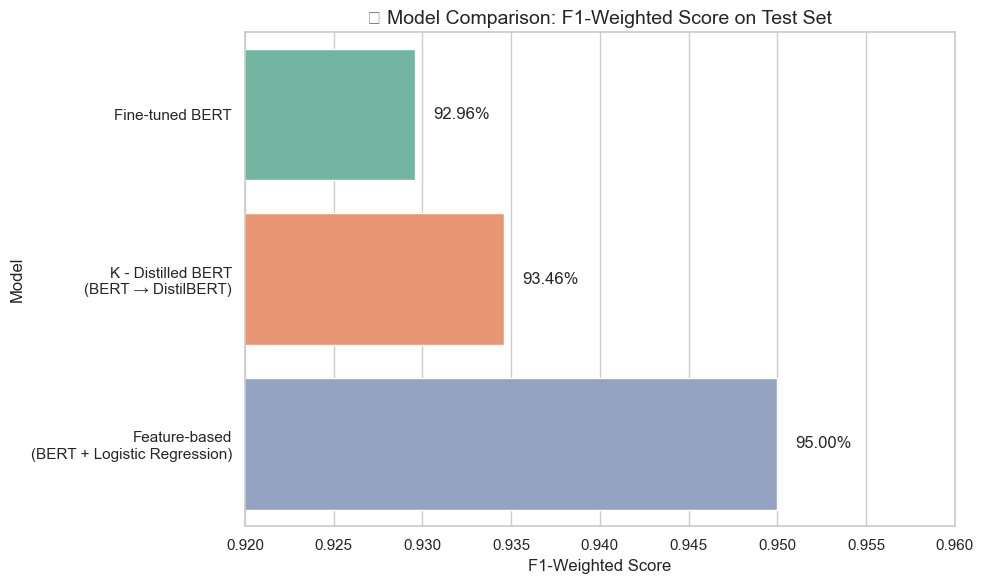

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set up the data
model_names = [
    "Fine-tuned BERT",
    "K - Distilled BERT\n(BERT → DistilBERT)",
    "Feature-based\n(BERT + Logistic Regression)"
]
# Use decimal format for F1 scores
f1_scores = [0.9296, 0.9346, 0.9500]

# Create DataFrame
df = pd.DataFrame({
    "Model": model_names,
    "F1 Score": f1_scores
})

# Set style
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="F1 Score", y="Model", data=df, palette="Set2")

# Add value labels
for index, value in enumerate(f1_scores):
    plt.text(value + 0.001, index, f"{value * 100:.2f}%", va='center')

# Title and labels
plt.title("📊 Model Comparison: F1-Weighted Score on Test Set", fontsize=14)
plt.xlabel("F1-Weighted Score")
plt.xlim(0.92, 0.96)
plt.tight_layout()
plt.show()
